**Smart Inventory Demand Forecasting**

Retail stores must keep enough stock to avoid stock-outs, but too much stock causes overstock costs (storage, cash tied up, waste).

The target is Units sold==Actaul demand

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib


Load + Basic Checks

In [ ]:
DATA_PATH = "/content/retail_store_inventory-2.csv"

df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"]) #convert to time stamp from str

print("Shape:", df.shape)
print("Date range:", df["Date"].min(), "->", df["Date"].max())
print("Missing values:\n", df.isna().sum())
print("Unique Values:\n", df.nunique())
print("Stores:", df["Store ID"].nunique(), "Products:", df["Product ID"].nunique(), "Days:", df["Date"].nunique())
df.head()


Shape: (73100, 15)
Date range: 2022-01-01 00:00:00 -> 2024-01-01 00:00:00
Missing values:
 Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64
Unique Values:
 Date                    731
Store ID                  5
Product ID               20
Category                  5
Region                    4
Inventory Level         451
Units Sold              498
Units Ordered           181
Demand Forecast       31608
Price                  8999
Discount                  5
Weather Condition         4
Holiday/Promotion         2
Competitor Pricing     9751
Seasonality               4
dtype: int64
Stores: 5 Products: 20 Days: 731


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


DATA vISUALIZATION

Numerical Data

In [ ]:
numerical_data = df.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features=numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 8 numerical features: 

['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']


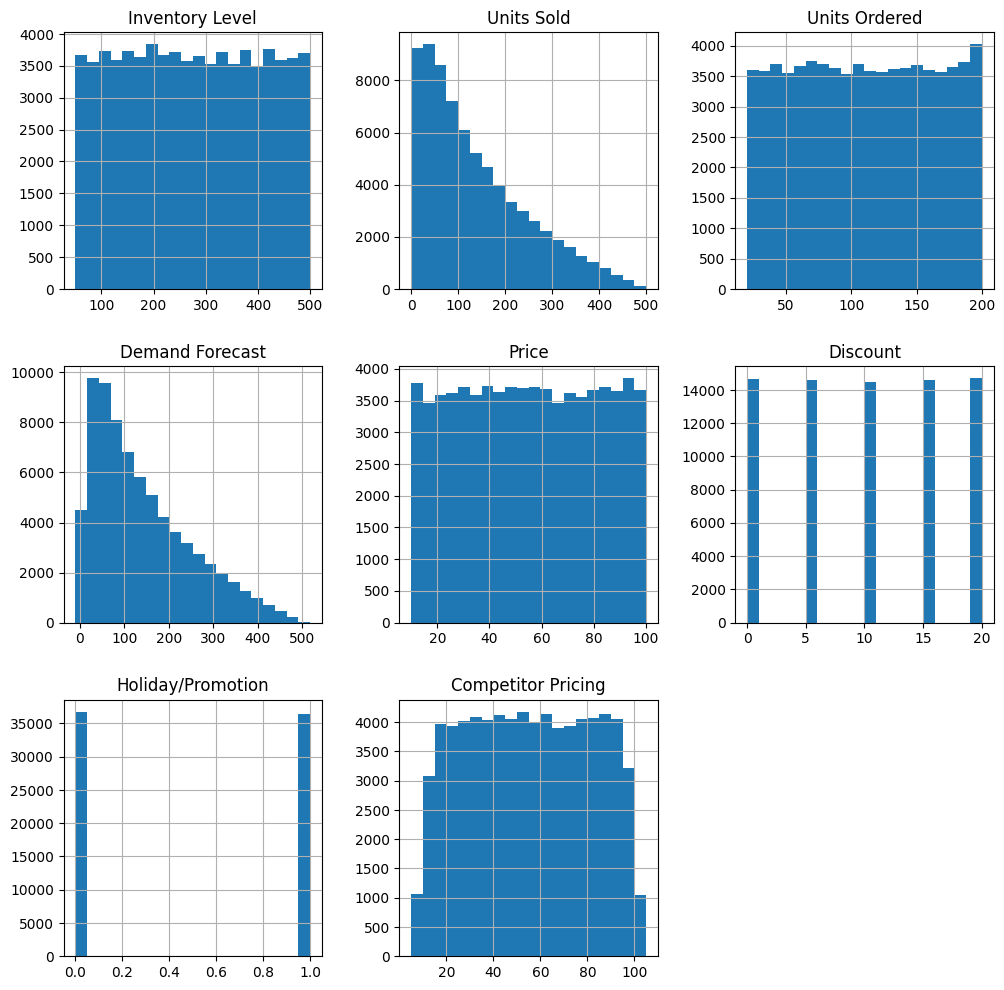

In [ ]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

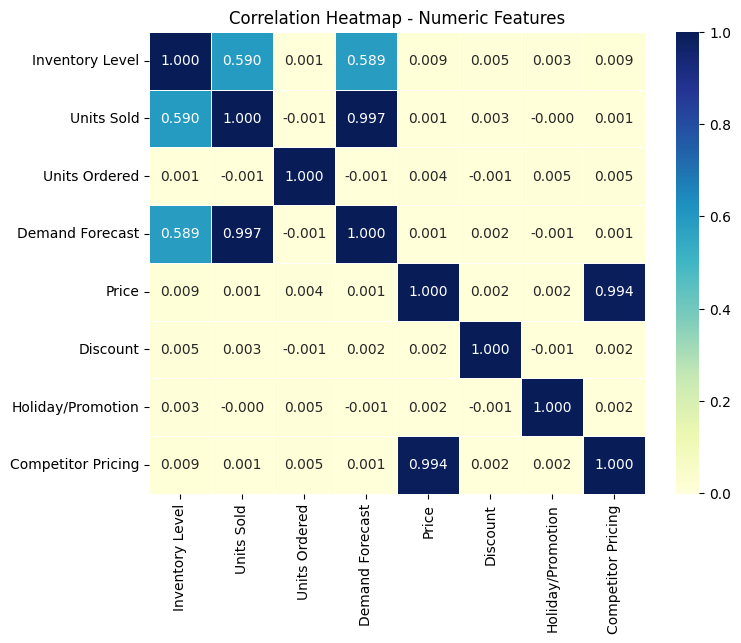

In [ ]:
correlation_matrix = numerical_data.corr()
correlation_matrix
# Plotting the heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=0.4)
plt.title("Correlation Heatmap - Numeric Features")
plt.show()

Categorical data

In [ ]:
#Selecting categoricalfeatures
categorical_data=df.select_dtypes(include= 'object')

#append the features of categorical_data to list
categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} Catagorical features:', '\n')
print(categorical_features)

There are 6 Catagorical features: 

['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']


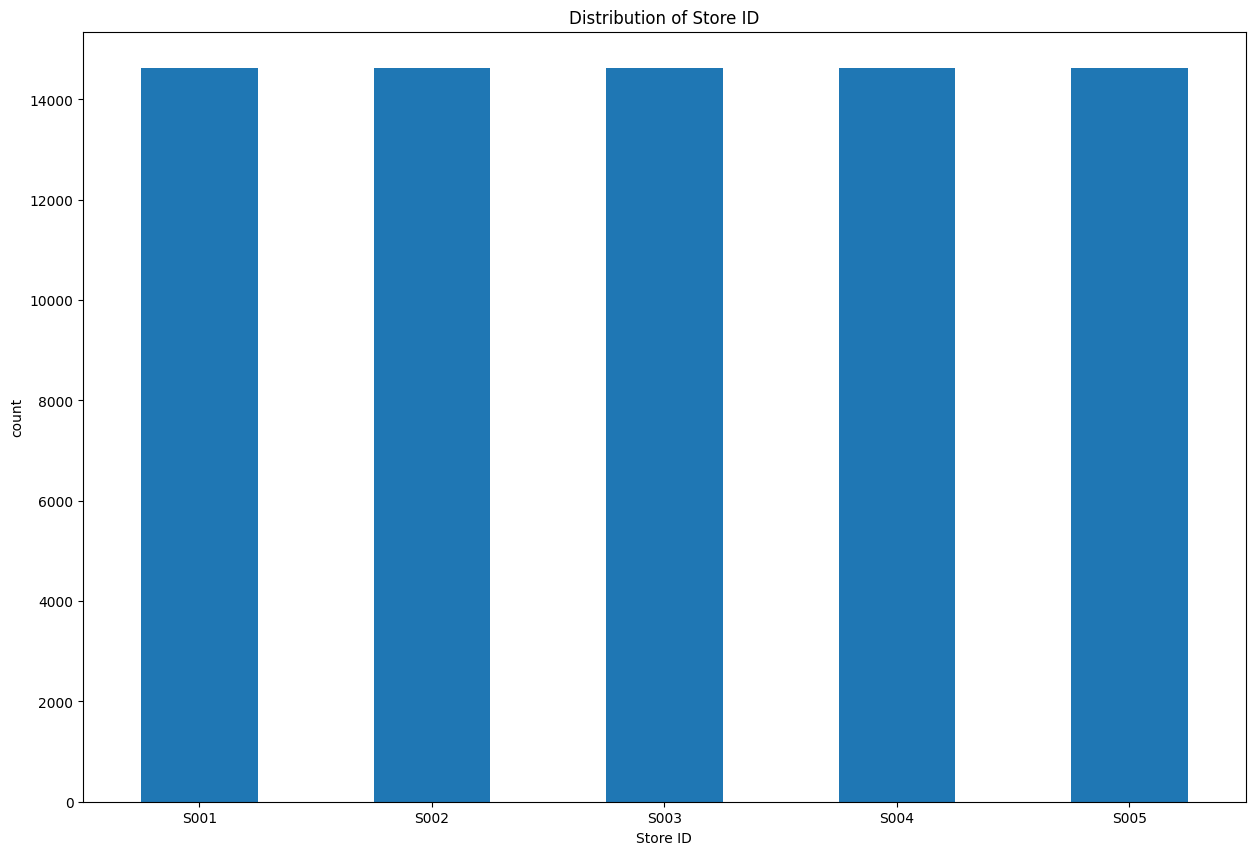

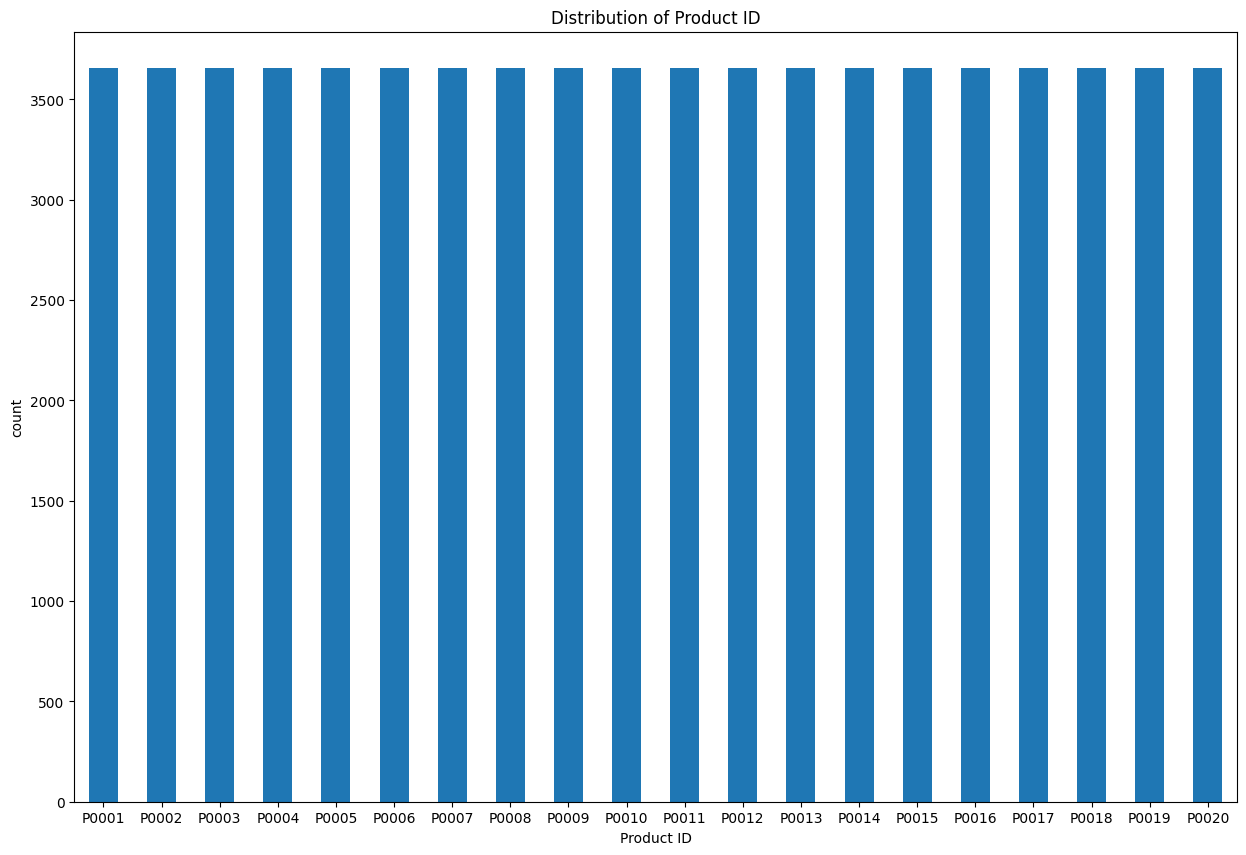

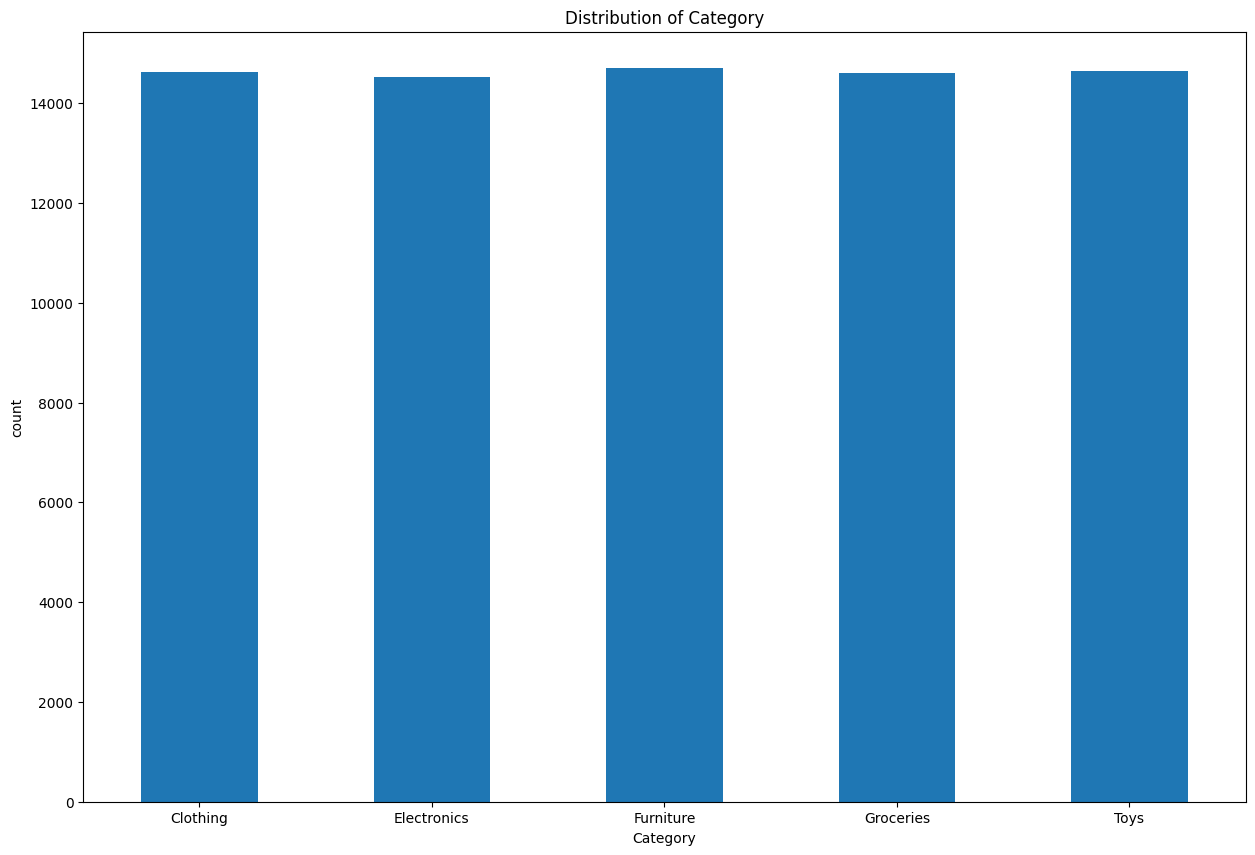

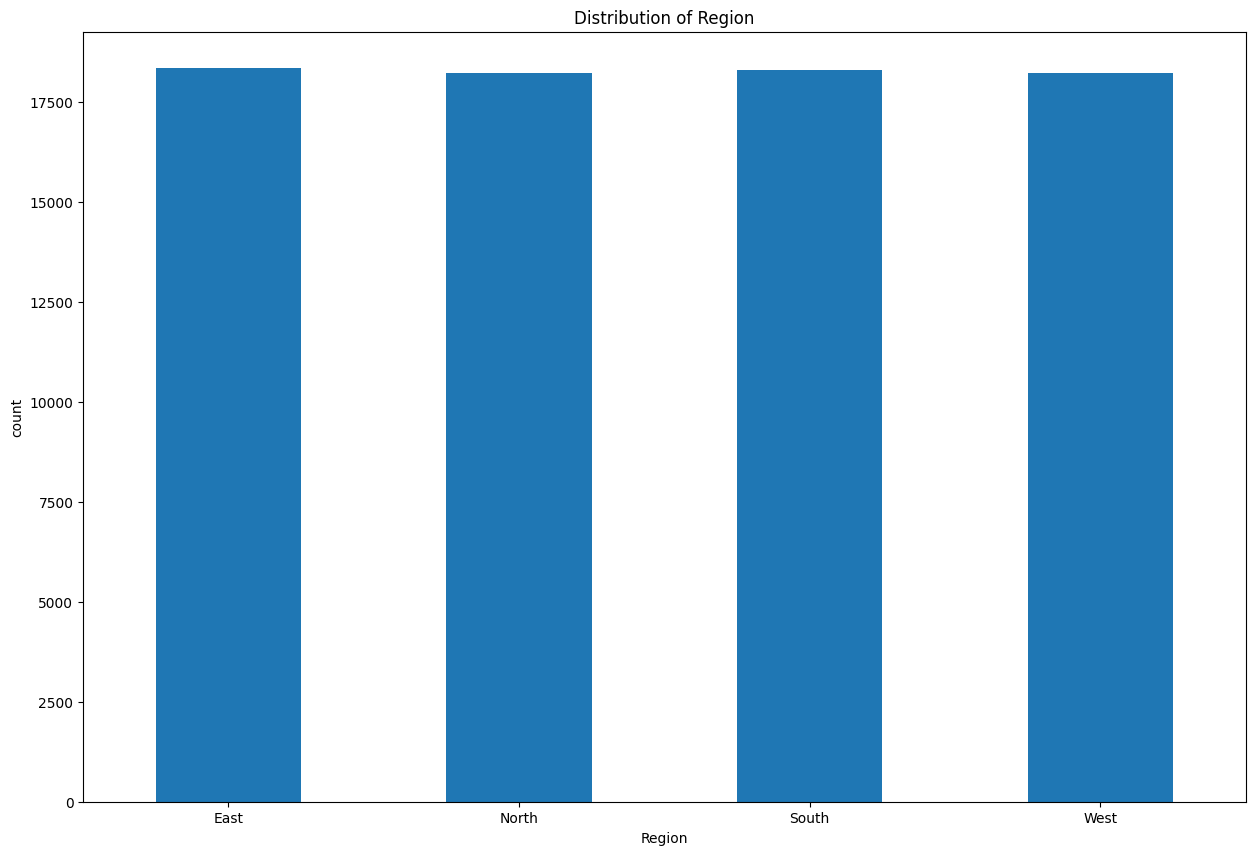

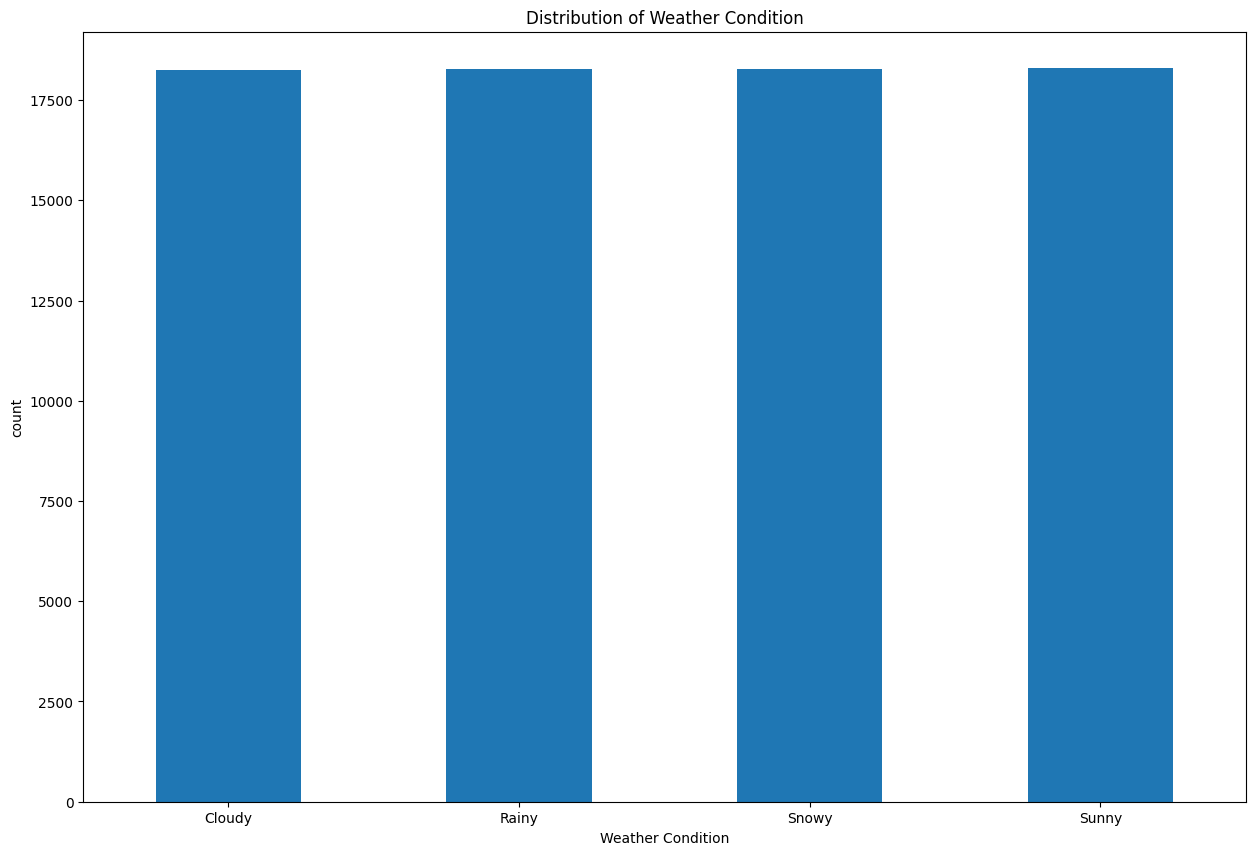

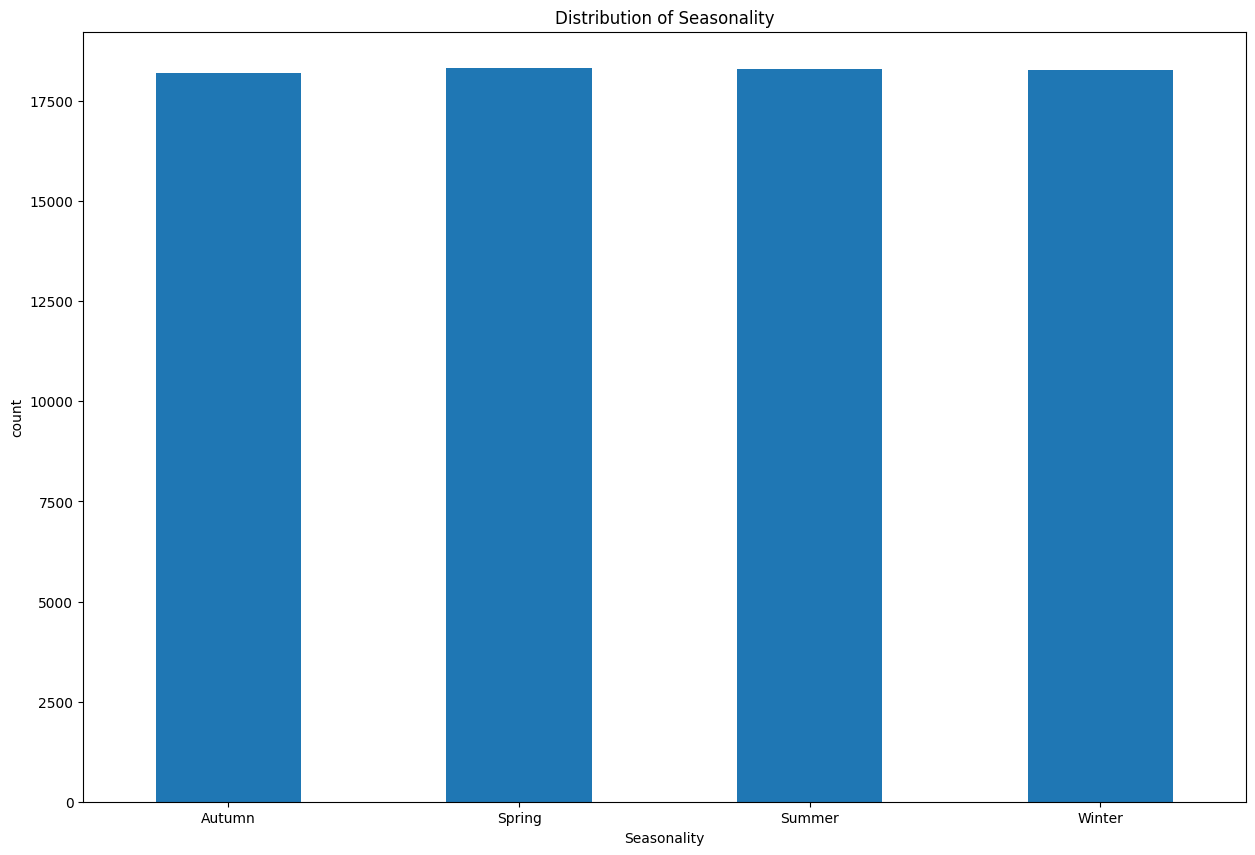

In [ ]:

for col in categorical_features:

    plt.title(f'Distribution of {col}')
    categorical_data[col].value_counts().sort_index().plot(kind='bar', rot=0, figsize=(15,10),xlabel=col,ylabel='count')
    plt.show()

EDA

/tmp/ipython-input-1046080759.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("bin").agg(


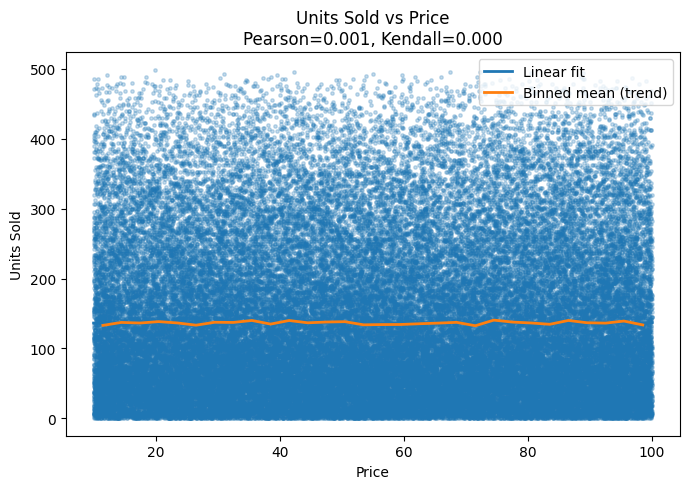

/tmp/ipython-input-1046080759.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("bin").agg(


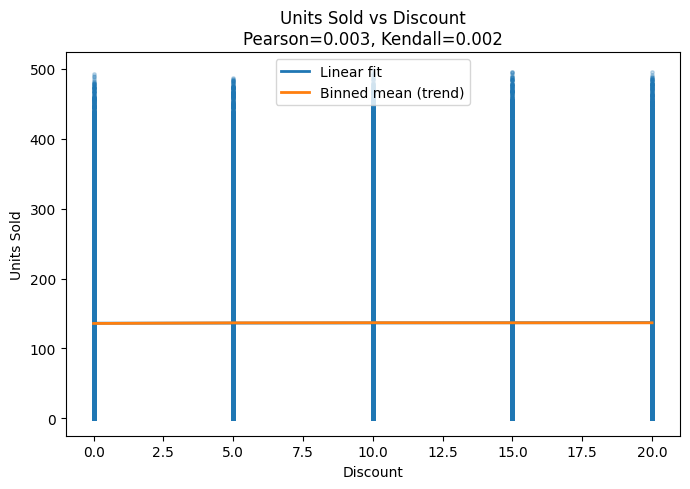

/tmp/ipython-input-1046080759.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("bin").agg(


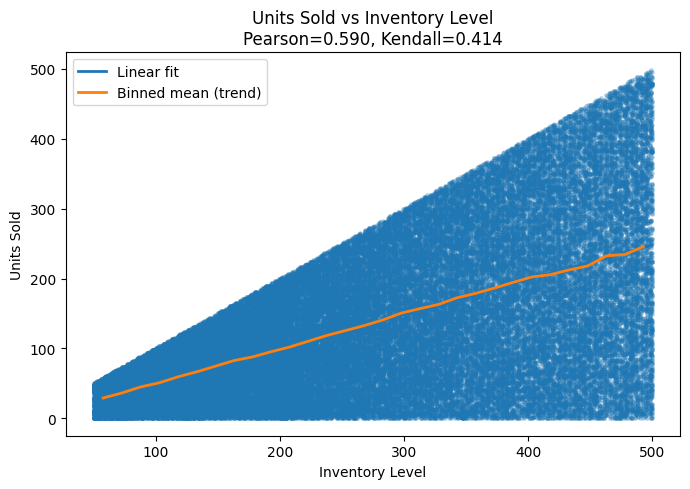

/tmp/ipython-input-1046080759.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("bin").agg(


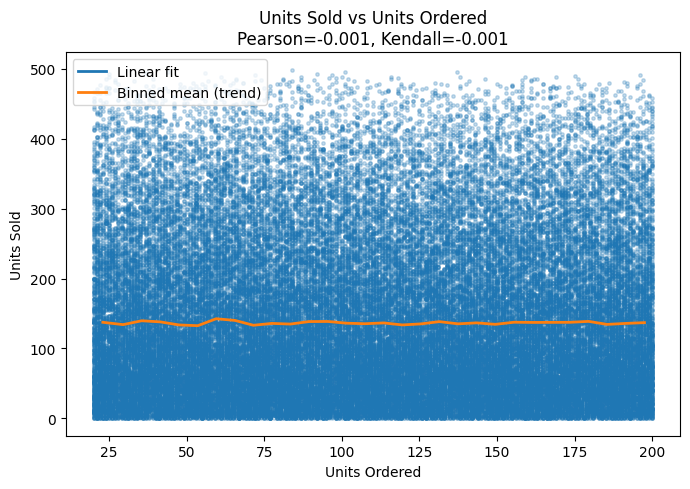

/tmp/ipython-input-1046080759.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = tmp.groupby("bin").agg(


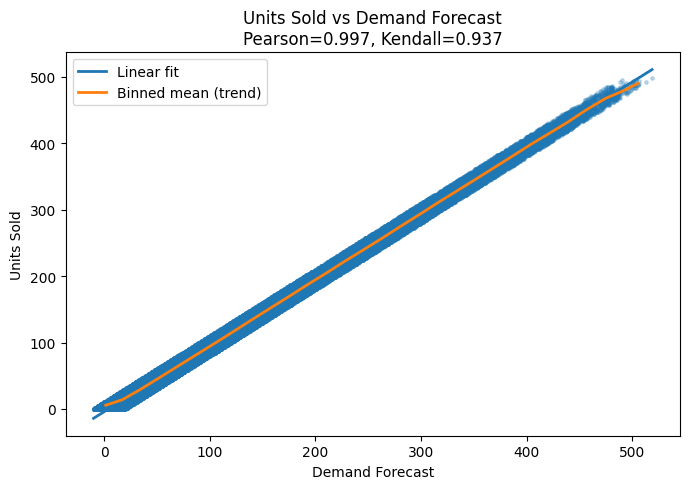

In [ ]:
def plot_linearity_check(df_in, target, features, bins=30):
    for feat in features:
        tmp = df_in[[feat, target]].dropna().copy()

        # Pearson & Kendall
        pear = tmp[[feat, target]].corr(method="pearson").iloc[0,1]
        ken  = tmp[[feat, target]].corr(method="kendall").iloc[0,1]

        x = tmp[feat].values
        y = tmp[target].values

        # Linear fit (simple)
        if np.std(x) > 0:
            m, b = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = m * x_line + b
        else:
            x_line, y_line = None, None

        # Binned mean curve (non-linear trend visual)
        # (works even when relationship is curved)
        tmp["bin"] = pd.cut(tmp[feat], bins=bins, duplicates="drop")
        bin_stats = tmp.groupby("bin").agg(
            x_mid=(feat, "mean"),
            y_mean=(target, "mean")
        ).dropna()

        plt.figure(figsize=(7, 5))
        plt.scatter(x, y, s=6, alpha=0.25)

        if x_line is not None:
            plt.plot(x_line, y_line, linewidth=2, label="Linear fit")

        plt.plot(bin_stats["x_mid"], bin_stats["y_mean"], linewidth=2, label="Binned mean (trend)")

        plt.title(f"{target} vs {feat}\nPearson={pear:.3f}, Kendall={ken:.3f}")
        plt.xlabel(feat)
        plt.ylabel(target)
        plt.legend()
        plt.tight_layout()
        plt.show()

features_to_check = [
    "Price", "Discount", "Inventory Level",
    "Units Ordered", "Demand Forecast"
]
plot_linearity_check(df, target="Units Sold", features=features_to_check, bins=30)


Pearson correlation is good for linear relationship and kandall correlation good for non linear relationship

In [ ]:
cols_check = ["Units Sold", "Demand Forecast", "Price", "Competitor Pricing"]
pear = df[cols_check].corr(method="pearson")
ken  = df[cols_check].corr(method="kendall")

print("Pearson(Units Sold, Demand Forecast):", pear.loc["Units Sold","Demand Forecast"])
print("Kendall(Units Sold, Demand Forecast):", ken.loc["Units Sold","Demand Forecast"])
print("Pearson(Price, Competitor Pricing):", pear.loc["Price","Competitor Pricing"])
print("Kendall(Price, Competitor Pricing):", ken.loc["Price","Competitor Pricing"])

print("\nDemand Forecast min value (should not be negative):", df["Demand Forecast"].min())


Pearson(Units Sold, Demand Forecast): 0.9968530435356925
Kendall(Units Sold, Demand Forecast): 0.9371592686189133
Pearson(Price, Competitor Pricing): 0.9938999960135461
Kendall(Price, Competitor Pricing): 0.9281179037268981

Demand Forecast min value (should not be negative): -9.99


In [ ]:
def plot_corr_side_by_side(df_in, cols):
    pearson = df_in[cols].corr(method="pearson")
    kendall = df_in[cols].corr(method="kendall")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, corr, title in zip(
        axes,
        [pearson, kendall],
        ["Pearson Correlation", "Kendall Correlation (ordinal/monotonic)"]
    ):
        im = ax.imshow(corr, vmin=-1, vmax=1)
        ax.set_title(title)

        ax.set_xticks(range(len(cols)))
        ax.set_yticks(range(len(cols)))
        ax.set_xticklabels(cols, rotation=45, ha="right")
        ax.set_yticklabels(cols)

        # annotate values
        for i in range(len(cols)):
            for j in range(len(cols)):
                ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
    cbar.set_label("Correlation")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-2262503824.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


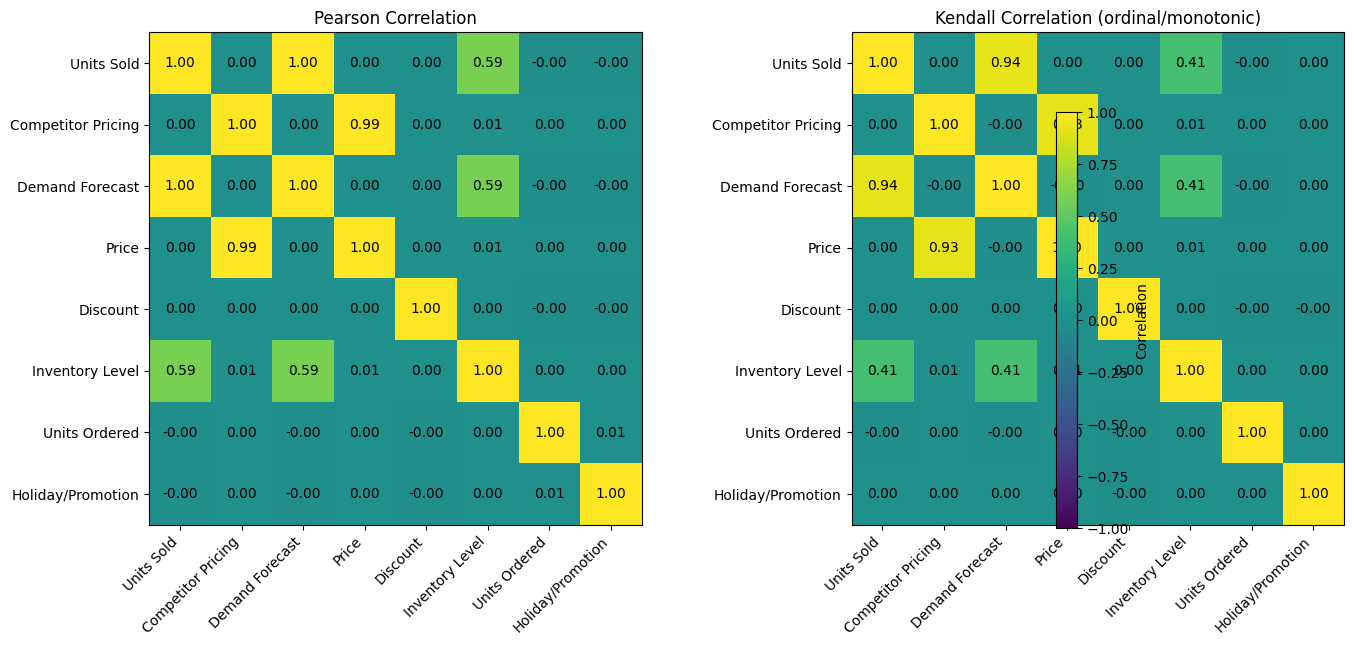

In [ ]:
corr_cols = ["Units Sold","Competitor Pricing","Demand Forecast", "Price", "Discount", "Inventory Level", "Units Ordered", "Holiday/Promotion"]
plot_corr_side_by_side(df, corr_cols)




                   Store ID  Product ID  Category  Region  Weather Condition  \
Store ID                1.0       0.000     0.000   0.000              0.000   
Product ID              0.0       1.000     0.004   0.000              0.004   
Category                0.0       0.004     1.000   0.005              0.002   
Region                  0.0       0.000     0.005   1.000              0.000   
Weather Condition       0.0       0.004     0.002   0.000              1.000   
Seasonality             0.0       0.004     0.000   0.000              0.002   

                   Seasonality  
Store ID                 0.000  
Product ID               0.004  
Category                 0.000  
Region                   0.000  
Weather Condition        0.002  
Seasonality              1.000  


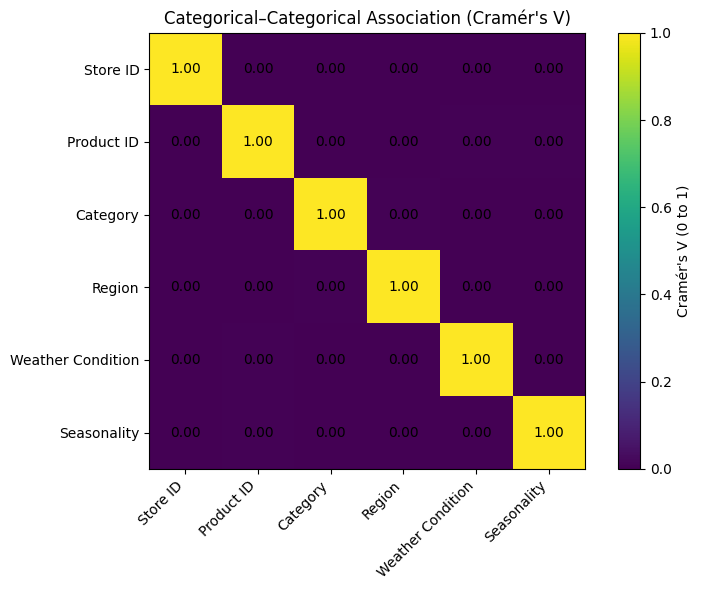

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Cramér's V for categorical-categorical association."""
    confusion = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion)
    n = confusion.to_numpy().sum()

    # bias correction (recommended)
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def cramers_v_matrix(df, cat_cols):
    mat = pd.DataFrame(np.eye(len(cat_cols)), index=cat_cols, columns=cat_cols)
    for i, c1 in enumerate(cat_cols):
        for j, c2 in enumerate(cat_cols):
            if j <= i:
                continue
            v = cramers_v(df[c1], df[c2])
            mat.loc[c1, c2] = v
            mat.loc[c2, c1] = v
    return mat

# Example categorical columns from your project
cat_cols = ["Store ID", "Product ID", "Category", "Region", "Weather Condition", "Seasonality"]

V = cramers_v_matrix(df, cat_cols)
print(V.round(3))
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(V, vmin=0, vmax=1)
plt.xticks(range(len(V.columns)), V.columns, rotation=45, ha="right")
plt.yticks(range(len(V.index)), V.index)

for i in range(len(V.index)):
    for j in range(len(V.columns)):
        plt.text(j, i, f"{V.iloc[i,j]:.2f}", ha="center", va="center")

plt.colorbar(label="Cramér's V (0 to 1)")
plt.title("Categorical–Categorical Association (Cramér's V)")
plt.tight_layout()
plt.show()

we can drop Competitor Pricing because close relation with price. reduce redundancy

In [ ]:
df = df.drop(columns=[  "Competitor Pricing" ])
df.head()



,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,Summer


MAE=(1/n)(summation of actual- prediction)

RMSE= root(1/n)(summation of (actual- prediction))^2)

bias_base = (y - baseline).mean()

In [ ]:
y = df["Units Sold"].values # create to numpy array
baseline = df["Demand Forecast"].values  #prediction

mae_base = mean_absolute_error(y, baseline)
rmse_base = np.sqrt(mean_squared_error(y, baseline))
bias_base = (y - baseline).mean()

print("Baseline (Demand Forecast) MAE:", mae_base)
print("Baseline (Demand Forecast) RMSE:", rmse_base)
print("Baseline bias (actual - forecast):", bias_base)



Baseline (Demand Forecast) MAE: 8.338075512995895
Baseline (Demand Forecast) RMSE: 10.01535001174343
Baseline bias (actual - forecast): -5.029850068399453


need this for lag or rolling mean and time-series sales

In [ ]:
df = df.sort_values(["Store ID", "Product ID", "Date"]).reset_index(drop=True)

df["day_of_week"] = df["Date"].dt.dayofweek
df["week_of_year"] = df["Date"].dt.isocalendar().week.astype(int) #iso bcz week is not uniquely defined but other does, week start from monday
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int) #weekend =1 nomral day=0


In [ ]:
df["inventory_gap"] = df["Inventory Level"] - df["Units Sold"] #present inventory status
df["sell_through_rate"] = np.where(df["Inventory Level"] > 0,
                                   df["Units Sold"] / df["Inventory Level"], #where(condi,if true, if false)
                                   0.0)
'''
Positive gap
→ Excess inventory (holding cost risk)

 Zero gap
→ Ideal inventory planning
 Negative gap
→ Stockout (lost sales, poor service)'''

'\nPositive gap\n→ Excess inventory (holding cost risk)\n\n Zero gap\n→ Ideal inventory planning\n Negative gap\n→ Stockout (lost sales, poor service)'

time-series features

In [ ]:
def add_lag_rolling_features(df_in, group_cols=("Store ID","Product ID"), target_col="Units Sold"):
    df2 = df_in.copy()
    df2 = df2.sort_values(list(group_cols) + ["Date"]).reset_index(drop=True) #drop=True means “don’t keep the old index as a column” #Wrong sorting = data leakage or incorrect history
    grp = df2.groupby(list(group_cols), sort=False)

    # Lags
    for lag in [1, 7, 14]: #lag is previos values
        df2[f"lag_{lag}"] = grp[target_col].shift(lag)  #shift(lag) bcz today gets yesterday’s sales

    # rolling is past many values
    for window in [7, 30]:   #shift(1) prevents the rolling features from using today’s target value. today gets yesterday’s sales
        df2[f"rolling_mean_{window}"] = grp[target_col].apply(
            lambda s: s.shift(1).rolling(window).mean()
        ).reset_index(level=list(range(len(group_cols))), drop=True)

        df2[f"rolling_std_{window}"] = grp[target_col].apply(
            lambda s: s.shift(1).rolling(window).std()
        ).reset_index(level=list(range(len(group_cols))), drop=True)

    return df2

df = add_lag_rolling_features(df)

# Drop early rows where lag/rolling features are NaN
lag_roll_cols = [c for c in df.columns if c.startswith("lag_") or c.startswith("rolling_")]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)  #emove rows with missing values

print("After feature engineering:", df.shape)
df.head()


After feature engineering: (70100, 28)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_weekend,inventory_gap,sell_through_rate,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
0,2022-01-31,S001,P0001,Clothing,West,410,200,152,212.24,70.78,...,0,210,0.487805,130.0,9.0,69.0,97.857143,66.564326,114.233333,91.181019
1,2022-02-01,S001,P0001,Groceries,East,419,279,84,297.26,34.49,...,0,140,0.665871,200.0,189.0,123.0,125.142857,63.127988,116.666667,92.498027
2,2022-02-02,S001,P0001,Electronics,South,415,38,149,53.13,52.49,...,0,377,0.091566,279.0,49.0,211.0,138.000000,84.011904,123.266667,96.827943
3,2022-02-03,S001,P0001,Clothing,South,345,71,186,84.02,27.71,...,0,274,0.205797,38.0,164.0,79.0,136.428571,86.032663,124.366667,95.617948
4,2022-02-04,S001,P0001,Furniture,South,121,25,25,37.72,16.84,...,0,96,0.206612,71.0,97.0,390.0,123.142857,88.218344,124.800000,95.335849


In [ ]:
target_col = "Units Sold"

feature_cols_num = [
    "Inventory Level",
    "Units Ordered",
    "Price",
    "Discount",
    "Holiday/Promotion",
    "day_of_week", "week_of_year", "month", "year", "is_weekend",
    "inventory_gap", "sell_through_rate",
    "lag_1", "lag_7", "lag_14",
    "rolling_mean_7", "rolling_mean_30",
    "rolling_std_7", "rolling_std_30",
]

feature_cols_cat = [
    "Store ID",
    "Product ID",
    "Category",
    "Region",
    "Weather Condition",
    "Seasonality",
]


ML pipeline: clean the data -> turn categories into numbers ->   train a Random Forest model

pipeline is needed for Prevents mistakes + leakage during cross-validation. to test your model multiple times

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), #NONE is replaced with median
    ("scaler", StandardScaler())   # scale to 0 and 1
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat) #one hot-encoding 0,1,2,3,4 from catagorical
    ]
)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42, #bootstrap
    n_jobs=-1 #use all cpu core
)

model = Pipeline(steps=[  #preprocessing rules + the trained forest are stored inside model
    ("preprocess", preprocess),  #pipeline takes raw data to correct prediction
    ("rf", rf_model)
])


Fold 1: MAE=0.89, RMSE=1.32
Fold 2: MAE=0.63, RMSE=0.93
Fold 3: MAE=0.50, RMSE=0.75
Fold 4: MAE=0.45, RMSE=0.67
Fold 5: MAE=0.43, RMSE=0.63

CV Average MAE: 0.58
CV Average RMSE: 0.86

OOF MAE: 0.58
OOF RMSE: 0.90
OOF R²: 1.000
OOF MAPE: 0.70%  (Accuracy≈99.30%)


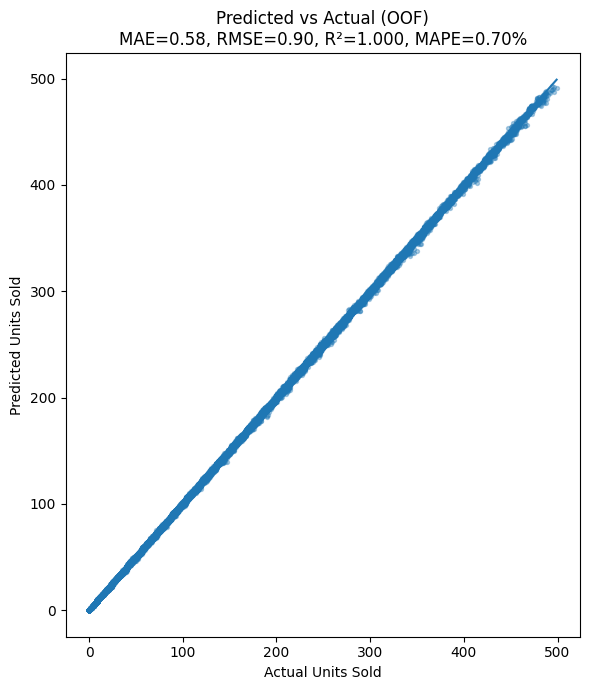

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Sort by time (important for time series) ---
df_cv = df.sort_values("Date").reset_index(drop=True) #needed bcz time-based splitting

# --- Features/target ---
X_all = df_cv[feature_cols_num + feature_cols_cat]
y_all = df_cv[target_col].values  # e.g., "Units Sold"

# --- OOF container (array)---
pred_oof = np.full(len(df_cv), np.nan) # Each data point is predicted only when it is in a test fold

# --- TimeSeries split on UNIQUE dates (train on earlier dates, test on later dates) --- to prevent Same date may appear in both train & test
unique_dates = np.array(sorted(df_cv["Date"].unique()))
tscv = TimeSeriesSplit(n_splits=5) #This will create 5 folds.In each fold:Train on earlier dates Test on later dates
# tscv will produce 5 train/test splits
maes, rmses = [], []

for fold, (tr_d_idx, te_d_idx) in enumerate(tscv.split(unique_dates), start=1):
    train_dates = unique_dates[tr_d_idx]
    test_dates  = unique_dates[te_d_idx]

    train_mask = df_cv["Date"].isin(train_dates).values #checks train_dates is in dates
    test_mask  = df_cv["Date"].isin(test_dates).values

    X_train, y_train = X_all.loc[train_mask], y_all[train_mask]
    X_test,  y_test  = X_all.loc[test_mask],  y_all[test_mask]

    model.fit(X_train, y_train) #train and learn from pipeline and create randomforestregerssor
    y_pred = model.predict(X_test)  #guess the output

    # store OOF preds for the test fold
    pred_oof[test_mask] = y_pred

    # fold metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    maes.append(mae)
    rmses.append(rmse)

    print(f"Fold {fold}: MAE={mae:.2f}, RMSE={rmse:.2f}")

print("\nCV Average MAE:", np.mean(maes).round(2))
print("CV Average RMSE:", np.mean(rmses).round(2))

# --- Overall OOF metrics (only rows that got predicted in some test fold) ---
mask = ~np.isnan(pred_oof)
y_true = y_all[mask]
y_pred = pred_oof[mask]

oof_mae = mean_absolute_error(y_true, y_pred)
oof_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
oof_r2 = r2_score(y_true, y_pred)

# avoid divide-by-zero; treat very small/zero actuals safely
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
accuracy_like = 100 - mape

print("\nOOF MAE:", f"{oof_mae:.2f}")
print("OOF RMSE:", f"{oof_rmse:.2f}")
print("OOF R²:", f"{oof_r2:.3f}")
print(f"OOF MAPE: {mape:.2f}%  (Accuracy≈{accuracy_like:.2f}%)")

# --- Plot: Predicted vs Actual (OOF) ---
plt.figure(figsize=(6, 7))
plt.scatter(y_true, y_pred, s=8, alpha=0.35)

mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])

plt.title(
    f"Predicted vs Actual (OOF)\n"
    f"MAE={oof_mae:.2f}, RMSE={oof_rmse:.2f}, R²={oof_r2:.3f}, MAPE={mape:.2f}%"
)
plt.xlabel(f"Actual {target_col}")
plt.ylabel(f"Predicted {target_col}")
plt.tight_layout()
plt.show()


In [ ]:
model.fit(X_all, y_all)
print("Final model trained on full dataset.")

Final model trained on full dataset.


In [ ]:
joblib.dump(model, "rf_inventory_pipeline.joblib")
print("Saved model -> rf_inventory_pipeline.joblib")


Saved model -> rf_inventory_pipeline.joblib


In [ ]:
loaded_model = joblib.load("rf_inventory_pipeline.joblib")
print("Loaded model OK.")

Loaded model OK.


In [ ]:
def recommend_inventory(pred_daily_demand, lead_time_days=7, service_factor=1.2):

    return (pred_daily_demand * lead_time_days) * service_factor

def compute_reorder_quantity(current_inventory, recommended_inventory):
    return np.maximum(recommended_inventory - current_inventory, 0)

In [ ]:
sample = df_cv.tail(10).copy()
sample_X = sample[feature_cols_num + feature_cols_cat]

sample["pred_units_sold"] = loaded_model.predict(sample_X)
sample["recommended_inventory"] = recommend_inventory(sample["pred_units_sold"], lead_time_days=7, service_factor=1.2)
sample["reorder_qty"] = compute_reorder_quantity(sample["Inventory Level"], sample["recommended_inventory"])

sample[["Date","Store ID","Product ID","Inventory Level","pred_units_sold","recommended_inventory","reorder_qty"]]

,Date,Store ID,Product ID,Inventory Level,pred_units_sold,recommended_inventory,reorder_qty
70090,2024-01-01,S004,P0005,217,111.723112,938.474143,721.474143
70091,2024-01-01,S004,P0006,364,194.537055,1634.111265,1270.111265
70092,2024-01-01,S004,P0007,134,116.919108,982.120508,848.120508
70093,2024-01-01,S004,P0008,390,365.348876,3068.930559,2678.930559
70094,2024-01-01,S004,P0009,115,46.744649,392.655054,277.655054
70095,2024-01-01,S004,P0010,382,112.526299,945.220912,563.220912
70096,2024-01-01,S004,P0011,155,106.397383,893.738020,738.738020
70097,2024-01-01,S004,P0012,85,62.835785,527.820591,442.820591
70098,2024-01-01,S004,P0014,386,168.694474,1417.033584,1031.033584
70099,2024-01-01,S005,P0020,117,6.072315,51.007444,0.000000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the Store–Product pair with the most observations
pair_counts = (
    df_cv
    .groupby(["Store ID", "Product ID"])
    .size()
    .sort_values(ascending=False)
)

# Extract the Store ID and Product ID
store_id, product_id = pair_counts.index[0]

print(f"Chosen Store ID: {store_id} | Product ID: {product_id}")


Chosen Store ID: S001 | Product ID: P0001


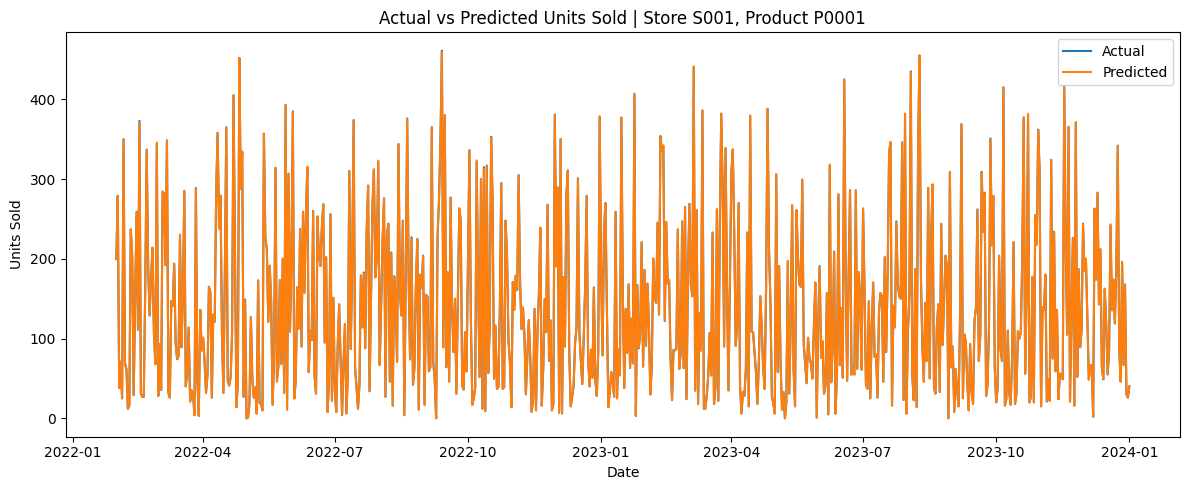

In [ ]:
# Filter one Store–Product
df_pair = df_cv[(df_cv["Store ID"] == store_id) & (df_cv["Product ID"] == product_id)].copy()
df_pair = df_pair.sort_values("Date").reset_index(drop=True)

# Predict
X_pair = df_pair[feature_cols_num + feature_cols_cat]
df_pair["pred_units_sold"] = loaded_model.predict(X_pair)  # or model.predict(X_pair)

# Plot: Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(df_pair["Date"], df_pair["Units Sold"], label="Actual")
plt.plot(df_pair["Date"], df_pair["pred_units_sold"], label="Predicted")
plt.title(f"Actual vs Predicted Units Sold | Store {store_id}, Product {product_id}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

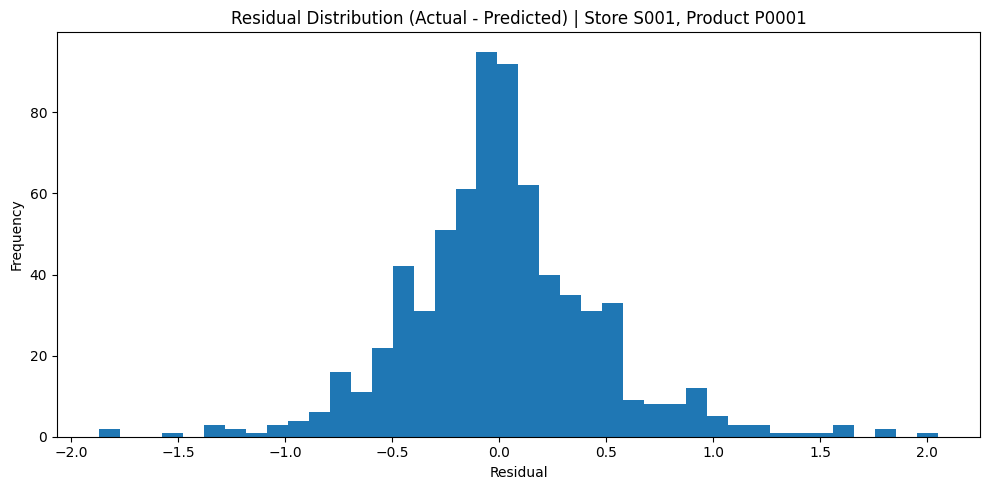

Residual mean (bias): 0.009769473994036885
Residual std: 0.46196378431263846
MAE: 0.3297742587067643
RMSE: 0.4617375264712814


In [ ]:
# Residuals (error)
df_pair["residual"] = df_pair["Units Sold"] - df_pair["pred_units_sold"]

# Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(df_pair["residual"], bins=40)
plt.title(f"Residual Distribution (Actual - Predicted) | Store {store_id}, Product {product_id}")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional: quick summary stats
print("Residual mean (bias):", df_pair["residual"].mean())
print("Residual std:", df_pair["residual"].std())
print("MAE:", np.mean(np.abs(df_pair["residual"])))
print("RMSE:", np.sqrt(np.mean(df_pair["residual"]**2)))